# In search of a generally applicable and efficient sampler [1]

## Motivation

Effective sampling from a non-Gaussian likelihood proved a crucial stumbling block for completion of a study investigating how errors in model structure can be accounted for during process design [1]. It took over 5 years to complete and a lack of a  Monte Carlo Markov Chain (MCMC) that could be tuned easily was one of the barriers we met. We settled for an adaptive Metropolis sampler in the study and were able to make it work but for a next study I hope to make this easier. In this post, I am reporting some exploratory work using a few variants of the slice sampler [2-3].



## Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import chi2
from sampler.gibbs import univariatenormal as gibbs
from sampler.metropolis import metropolis as metro

## Toy example 

To illustrate the performance of the selected samplers, I will use a simple statistical problem of estimating the mean and standard deviation of a univariate normal distribution. A total of $N=42$ randomly sampled data points, $x_i$ ($i = 1, 2, \ldots 42$), are used for this estimation. These are sampled from a univariate normal distribution as well so the applied model structure and the data-generating system match each other perfectly (no model-reality mismatch). The mean ($\mu^*$) and standard deviation  ($\sigma^*$) for the data-generating system are set to $\mu^*=2$ and $\sigma^*=3$. These parameter values are considered unknown during the model identification stage and need to be estimated from the data $x_i$.

(0.5, 42.5)

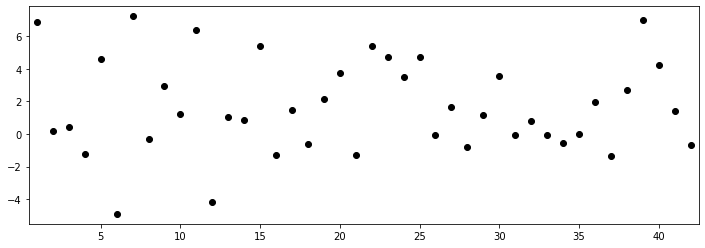

In [2]:
N = 42
sigma_star = 3
mu_star = 2

np.random.seed(1)
x = np.random.randn(N)*sigma_star+mu_star

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(np.arange(N)+1,x,'ko')
ax.set_xlim([0.5,42.5])

The Bayesian framework is adopted for estimation of the parameters using Jeffrey's prior for the prior likelihood ($L(\mu,\sigma)$). Practically, this is achieved by replacing the standard deviation parameter ($\sigma$) with the logarithm of its squared value ($\phi := \log(\sigma^2)$). As a result one can use a uniform prior for the parameters, which are now $\mu$ and $\phi$:
$$L(\mu,\phi) = 1$$
The data likelihood $L(\mathbf{x}\big|\mu,\phi)$, which evaluates how likely the data are given parameter values,  is then:
$$L(\mathbf{x}\big|\mu,\phi) = \big(\frac{1}{2 \pi e^\phi} \big)^{\frac{N}{2}} e^{\frac{ \sum_i{ (x_i - \mu)^2} }{ 2 ~ e^\phi } }$$

The posterior density, which evaluates the distribution of the parameters given the data set, is obtain by application of Bayes' rule:
$$P(\mu,\phi \big|\mathbf{x})  = \frac{L(\mathbf{x}|\mu,\phi) L(\mu,\phi)}{L(\mathbf{x})} = \frac{L(\mathbf{x}|\mu,\phi) L(\mu,\phi)}{\int_{\mu,\phi}{L(\mathbf{x}|\mu,\phi) L(\mu,\phi)}}= \frac{\big(\frac{1}{2 \pi e^\phi} \big)^{\frac{N}{2}} e^{\frac{ \sum_i{ (x_i - \mu)^2} }{ 2 ~ e^\phi } }}{\int_{\mu,\phi}{\big(\frac{1}{2 \pi e^\phi} \big)^{\frac{N}{2}} e^{\frac{ \sum_i{ (x_i - \mu)^2} }{ 2 ~ e^\phi } } } }$$

An analytical solution for the integral in the denominator is not available. To evaluate the posterior density, one ca resort to Monte Carlo sampling techniques to approximate this integral numerically. To this end, one requires evaluations of the numerator, which is called the posterior likelihood:
$$L(\mu,\phi \big|\mathbf{x})  = \big( \frac{1}{2 \pi e^\phi} \big)^{\frac{N}{2}} e^{\frac{ \sum_i{ (x_i - \mu)^2} }{ 2 ~ e^\phi } }$$

For practical purposes, it is easier to work with the posterior log-likelihood, which is:
$$LL(\mu,\phi \big|\mathbf{x}) := \log{\big( L(\mu,\phi \big|\mathbf{x}) \big)} = -\frac{N}{2} \big( \log{2 \pi} + \phi + \frac{\sum_i{ {(x_i - \mu)}^2 } }{ N ~ e^\phi } \big) $$

The next figure shows this posterior likelihood as well as the true yet unknown parameters of the data-generating system (red star) and the maximum likelihood estimates (yellow dot). These are close but not the same because the amount of data is fairly small.

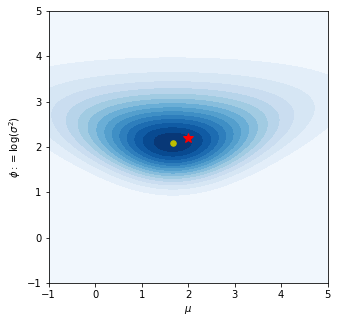

In [3]:
def loglikelihood(x,par):
    if len(np.shape(par))==1:
        par = par[None,:]
        pass
    
    mu = par[:,0]
    gamma = par[:,1]
    
    logsigma2 = gamma
    sigma2 = np.exp(logsigma2)
    N = len(x)
    E2 = (x[None,:]-mu[:,None])**2
    SSE = np.sum(E2,axis=1)
    LL = -N/2*np.log(np.pi)-N/2*logsigma2-1/(2*sigma2)*SSE
    return LL


LLfun = lambda par: loglikelihood(x,par)

nGrid =1001
limit = 5
x_min = -1
y_min = -1
x_max = +limit
y_max = +limit
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nGrid),np.linspace(y_min, y_max, nGrid))
xx0, yy0 = np.meshgrid(np.linspace(-x_max, x_max, nGrid),np.linspace(-y_max, y_max, nGrid))

Z_mesh = np.c_[xx.ravel(), yy.ravel()]
Y_mesh = np.c_[xx0.ravel(), yy0.ravel()]
logdens_mesh = np.reshape(LLfun(Z_mesh),np.shape(xx))

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.contourf(xx, yy,  (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);
ax.plot(mu_star,np.log(sigma_star**2),'r*',markersize=11)
ax.plot(np.mean(x),np.log(np.std(x)**2),'y.',markersize=11)
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\phi := \log(\sigma^2)$');

## Task at hand

To sample from the target distribution there are a number of Monte Carlo Markov Chain (MCMC) samplers available. I am looking for a sampler that can do this effectively without needing too many assumptions. For this post, I will show results with three samplers:

* The Gibbs sampler: This sampler obtains new values for $\mu$ and $\phi$ sequentially. To this end, it is required that the posterior density for each parameter, conditional to the other is known precisely. More specifically one requires an analytical expression for the integrals of $L(\mu\big|\phi,\mathbf{x})$ and $L(\phi\big|\mu,\mathbf{x})$. This available for the toy example but is a very strong assumption in practice. The major benefit is that this sampler is fairly effective at suppressing random walk beahviour. The Gibbs sampler will act as a reference point to compare the other samplers against.

* The Metropolis sampler: This sampler makes no strong assumptions. A particular advantage is that one does not require  analytical expressions for any integral. The major disadvantage is that it requires the tuning of a length-scale parameter to sample efficiently from the distribution and avoid random-walk behaviour. In my experience, this tuning is a stumbling block and a source of distrust in the obtained results.

* The Slice sampler: This sampler makes no strong assumptions either. It also includes a tuning parameter but -alledgedly- the results are less sensitive to its value. 

The main question is whether any of the slice sampler offers tangible benefits over the Metropolis sampler, this without requiring the assumptions of the Gibbs sampler.

## Implementation and illustration

All code is available at [LINK]. The next paragraphs show some results with each sampler.

### Gibbs sampler

The Gibbs sampler samples a value for each parameter in a fixed order ($\mu$ first, $\phi$ second). A new sample is obtained when all parameter values are updated. The next figure shows the sequence of the first 50 samples starting with the initial parameters set at the origin ($\mu_0=0,\phi_0=0$).

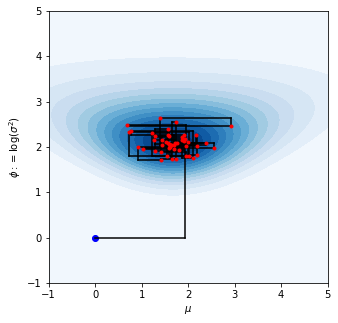

In [4]:
S = 50
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.contourf(xx, yy,  (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);

np.random.seed(11)
gibbs(x,S,ax=ax)

ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\phi := \log(\sigma^2)$');

### Metropolis sampler

The Metropolis sampler samples values for all parameters simultaneously. It is a special case of the Metropolis-Hastings sampler using a symmetric proposal distribution. Details of the Metropolis sampler can be found here. The length-scale parameter for the proposal distribution is set to $\delta = 0.25$ for illustration. The next figure shows the sequence of the first 50 samples, again starting with initial parameters at the origin ($\mu_0=0,\phi_0=0$). One can see that it takes a while before the sampler reaches the high-density region. The speed by which this happens depends on the length-scale tuning parameter $\delta$. In practice, this phenomenon is avoided by discarding the first set of samples, known as the burn-in phase.

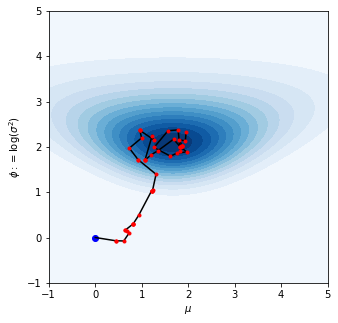

In [5]:
S = 50
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.contourf(xx, yy,  (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);

gamma = 0.25
theta0 = np.zeros(2)

np.random.seed(11)
metro(LLfun,S,theta0,gamma,ax=ax)

ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\phi := \log(\sigma^2)$');

### Slice sampler

The slice sampler itself samples from a univariate distribution. It has a length-scale tuning parameter, like the Metropolis sampler. However, this only determines an initial search window, which is expanded or contracted for every new sample.

The generalization to a multi-parameter setting is easy. One simple approach consist of sampling the value for each parameter conditional to the values of the other parameter. This is similar to the Gibbs sampler. A key difference is that the slice sampler does not require an analytical expression for the conditional distribution of each parameter. The next figure shows the first 50 samples obtained in this way, once more starting at the origin.

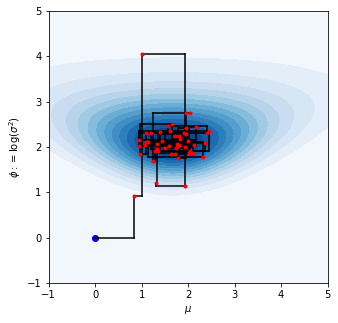

In [6]:
from sampler.slice import conditionalslice as slicer

S = 50
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.contourf(xx, yy,  (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);

gamma = 0.25
theta0 = np.zeros(2)
m = 10 ;
p = 8 ;
mode = 'double'
adapt=0

np.random.seed(11)
slicer(LLfun,S,theta0,mode,m,p,gamma,adapt=0,ax=ax)

ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\phi := \log(\sigma^2)$');

## Comparative analysis

### Performance measures

* Effective sample size (ESS). All Monte Carlo Markov Chain (MCMC) samplers exhibit some autocorrelation because the position of any new sample depends on the position of the previous sample. An ideal sampler will produce series of samples that are minimally correlated. To quantify the amount of correlation I will compute the effective sample size (ESS). This value estimates the number of independent samples that exist within the correlated series of samples.

* Effective sample rate (ESR). Some samplers require more evaluations of the posterior likelihood per sample than others. In general, reducing the amount of autocorrelation requires additional computation. To enable an effective comparison based on computational efficiency, I will compute the effective sample production rate by dividing the ESS by the time needed to compute them.

### Practical implementation

A total number of $S=10'000$ samples is generated with:

* The 4 samplers discussed above

* Using 9 distinct length-scales for the Metropolis, Slice, and adaptive Slice samplers.

A burn-in phase of 2'000 samples is applied. The adaptive Slice sampler is used with an update of the coordinate system every 1'000 samples. The next pieces of code execute all runs and compute the ESS and EPR for all.

In [7]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

pandas2ri.activate()

mcmcse = importr('mcmcse')
robjects.r('''
        # create a function `mESS`
        mESS <- function(X, verbose=FALSE) {
            if (verbose) {
                cat("I am calling mESS().\n")
            }
            multiESS(as.data.frame(X))
        }
        ''')
r_mESS = robjects.globalenv['mESS']


C:\Users\2kv\.conda\envs\data_science\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [8]:
burnin = 2000
S = 10000

seed = 5
np.random.seed(seed)
tic = time.perf_counter()
Z_Gibbs = np.array(gibbs(x,S,ax=ax))
toc = time.perf_counter()
ess_Gibbs = r_mESS(Z_Gibbs[burnin:,:])[0]
ComputeTime_Gibbs = toc-tic

loggammas = np.arange(-4,4.1)
gammas = 2**loggammas
G = len(gammas)
methods = ['Metropolis','Slice']

M = len(methods)    
ComputeTime = np.ones([G,M])*np.nan
ESS = np.ones([G,M])*np.nan
ZZ = []
for iScale in range(G):
    gamma = gammas[iScale]
    #print(gamma)
    for iMethod in range(M):
        method = methods[iMethod]
        #print(gamma,method)
        xComplete = False
        seed = 0
        while not(xComplete):
            #print(gamma,method,seed)
            try:
                np.random.seed(seed)
                tic = time.perf_counter()
                if method=='Metropolis':
                    Z = np.array(metro(LLfun,S,theta0,gamma) )
                    pass
                elif method=='Slice':
                    Z = np.array(slicer(LLfun,S,theta0,mode,m,p,gamma,adapt=0));
                    pass
                toc = time.perf_counter()
                ess = r_mESS(Z[burnin:,:])[0]
                xComplete = True
                pass
            except:
                seed +=1
            pass
        
        ComputeTime[iScale,iMethod] = toc-tic
        ESS[iScale,iMethod] = ess
        if gamma==1:
            ZZ.append(Z)
            pass
        pass
    pass

C:\Users\2kv\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\2kv\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\2kv\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in true_divide
  


The next figure shows the effective sample size (ESS) for all 19 runs: 1 run of the Gibbs sampler and 9 runs for the Metropolis and slice samplers, each run with a different length scale value ($\delta$). The ESS values are computed after removal of the burn-in phase. The Gibbs sampler represents the ideal sampler and delivers an ESS matching the actual number of samples (8000).

The Metropolis sampler does rather badly, with the best ESS value under 1000. At best, only every 9th sample can be considered an independent sample. The ESS is very sensitive to the length scale parameter and reaches a low value of 3  for the largest length scale value. 

The slice sampler does much better. First, the estimated ESS never drops below 7000. Second, there is no strong sensitivity to the chosen length scale.

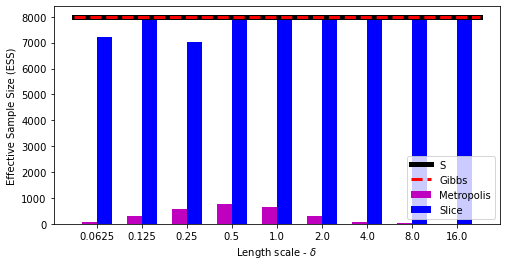

In [9]:
colors = ['m','b','c'] 
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array([loggammas[0]-1/2,loggammas[-1]+1/2,]),np.array([S-burnin,S-burnin]),'k-',lw=5,label='S')
ax.plot(np.array([loggammas[0]-1/2,loggammas[-1]+1/2,]),np.array([ess_Gibbs,ess_Gibbs]),'r--',lw=3,label='Gibbs')
for iMethod in range(M):
    method = methods[iMethod]
    ax.bar(x=loggammas+(iMethod-1/2)/3,height=ESS[:,iMethod],label=method, width=1/3, color =colors[iMethod])
    pass
ax.set_xlabel('Length scale - $\delta$')
ax.set_ylabel('Effective Sample Size (ESS)')
ax.set_xticks(loggammas)
ax.set_xticklabels(gammas)
ax.legend();

The next figure shows the effective sample rate (ESR). One can see that for some values of the length scale, the Metropolis sampler does better than all other samplers, including the Gibbs sampler. However, the ESR is very sensitive to the length scale parameter.

In contrast, the slice sampler does better than the Gibbs sampler for every tested length scale. While it is sensitive to the chosen length scale, this appears less dramatic an effect.

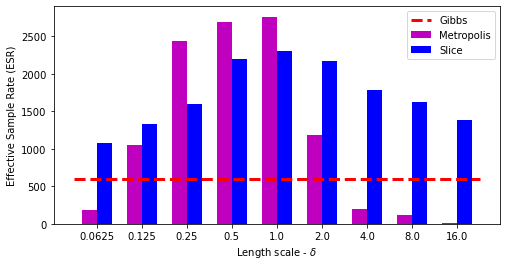

In [10]:
ESR = ESS/(S-burnin)*S/ComputeTime
ESR_Gibbs = ess_Gibbs/(S-burnin)*S/ComputeTime_Gibbs

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(np.array([loggammas[0]-1/2,loggammas[-1]+1/2,]),np.array([ESR_Gibbs,ESR_Gibbs]),'r--',lw=3,label='Gibbs')
for iMethod in range(M):
    method = methods[iMethod]
    ax.bar(x=loggammas+(iMethod-1/2)/3,height=ESR[:,iMethod],label=method, width=1/3, color =colors[iMethod])
    pass
ax.set_xlabel('Length scale - $\delta$')
ax.set_ylabel('Effective Sample Rate (ESR)')
ax.set_xticks(loggammas)
ax.set_xticklabels(gammas)
ax.legend();

The next figure shows the samples obtained with the Gibbs sampler as well as the Metropolis and slice samplers with the length scale set to 1 ($\delta = 1$). Visually, each of these samplers deliver similar results.

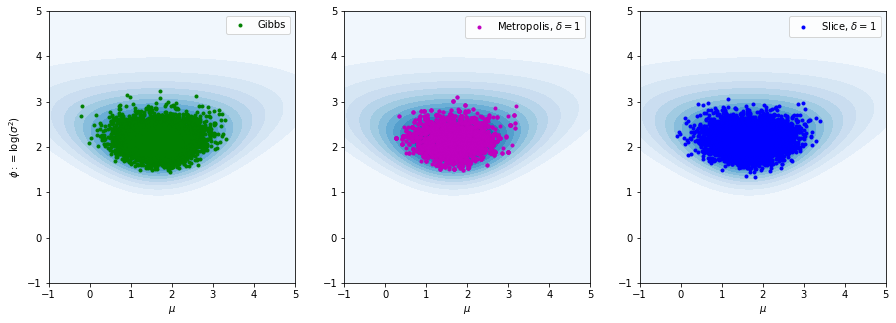

In [11]:
fig, axs = plt.subplots(1,M+1,figsize=((M+1)*5,5))

ax = axs[0]
ax.contourf(xx, yy, (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.plot(Z_Gibbs[burnin:,0],Z_Gibbs[burnin:,1],'.',color='g',label='Gibbs')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\phi := \log(\sigma^2)$')
ax.legend()

ax = axs[1]
ax.contourf(xx, yy, (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.plot(ZZ[0][burnin:,0],ZZ[0][burnin:,1],'.',color=colors[0],label=methods[0]+', $\delta=1$')
ax.set_xlabel('$\mu$')
ax.legend()

ax = axs[2]
ax.contourf(xx, yy, (np.exp(logdens_mesh))**(1/8), cmap='Blues', alpha=1,levels=17);
ax.set_xlim([x_min,x_max])
ax.set_ylim([y_min,y_max])
ax.plot(ZZ[1][burnin:,0],ZZ[1][burnin:,1],'.',color=colors[1],label=methods[1]+', $\delta=1$')
ax.set_xlabel('$\mu$')
ax.legend();

## Take home message

* The slice sampler appears very promising for general-purpose sampling based on a simple toy example.